In [109]:
from firebehavior import *
import pandas as pd



In [110]:
###  Inputs



# La ruta al Weather debe ser correcta
ruta_archivo = './Weather.csv'

# Cargar el archivo
Weather = pd.read_csv(ruta_archivo)

i = 0  # fila i del archivo Weather
wdfh = Weather.iloc[i]  # seleccionando una fila en formato DataFrame

ftype = "C1"  # Ejemplo de tipo de combustible

# Ejemplo de cálculo de jd, lat, long, etc. (ajustar según el formato real de tus datos)
jd = (pd.to_datetime(wdfh['datetime']) - pd.to_datetime("01-Jan-2001")).days
lat = 51.621244  # Ejemplo de latitud
long = -115.608378  # Ejemplo de longitud
elev = 2138.0  # Ejemplo de elevación geográfica
ps = 0  # Porcentaje de pendiente
saz = 0  # Azimut de la pendiente (dirección cuesta arriba)


In [111]:
# Cálculos

# Consumo de combustible superficial
sfc = surf_fuel_consump(ftype, wdfh, FuelConst2)  # en [Kg/m2]

# Tasa de propagación de la cabeza del incendio (HROS = ROS) (incluye efecto de pendiente y acumulación)
ros, wsv, raz, isi = rate_of_spread(ftype, wdfh, a, b, c, ps, saz, FuelConst2, bui0, q)  # [m/min]

# Intensidad del fuego superficial
sfi = fire_intensity(sfc, ros)  # en [kW/m]

# Contenido de humedad foliar
fmc = foliar_moisture(lat, long, elev, jd)  # en [%]

# Intensidad crítica de la superficie
csi = crit_surf_intensity(CBH[ftype], fmc)

# Determinar el tipo de fuego y realizar cálculos adicionales
if ("C1" <= ftype <= "C7") or ("M1" <= ftype <= "M4"):  # CBH > 0
    # Tipo de fuego = corona
    if sfi > csi:
        rso = max(csi / (300 * sfc), 0.0)  # Tasa crítica de propagación
        cfb = max(1 - math.exp(-0.23 * (ros - rso)), 0.0)  # Fracción de la corona quemada
        cfc = CFL[ftype] * cfb  # Consumo de combustible de la corona
        if ftype in ["M1", "M2"]:
            cfc *= FuelConst2["pc"] / 100.0  # actualización
        elif ftype in ["M3", "M4"]:
            cfc *= FuelConst2["pdf"] / 100.0  # actualización
        tfc = sfc + cfc
        ros = final_ros(ftype, fmc, isi, cfb, ros)
        fi = fire_intensity(tfc, ros)  # Intensidad total del fuego
        firetype = "crown"
    else:
        cfb = 0
        cfc = 0
        tfc = sfc
        fi = sfi
else:  # CBH == 0.0
    cfb = 0
    cfc = 0
    tfc = sfc
    fi = sfi

# Efecto FFMC
ffmc = wdfh["FFMC"]
ff = ffmc_effect(ffmc)

# Relación longitud/ancho
lb = length2breadth(ftype, wsv)

# ISI de retroceso
bisi = backfire_isi(wsv, ff)

# Tasa de propagación de retroceso
brss = backfire_ros(ftype, bisi, wdfh, a, b, c, FuelConst2, bui0, q)

if ("C1" <= ftype <= "C7") or ("M1" <= ftype <= "M4"):
    bros, bfi, bfc, back_firetype = back_fire_behaviour(ftype, sfc, brss, csi, rso, fmc, bisi, CFL)

# Tasa de propagación lateral
fros = flankfire_ros(ros, bros, lb)

# Comportamiento del fuego lateral
ffi, ffc, flank_firetype = flank_fire_behaviour(ftype, sfc, fros, csi, rso, CFL)

# Tiempo transcurrido
elapsetime = 60  # [min]

# Aceleración
accn = acceleration(ftype, cfb)

# Distancia y tasa de propagación de la cabeza del incendio
hdist, hrost = spread_distance(ros, elapsetime, accn)

# Distancia y tasa de propagación de retroceso
bdist, brost = spread_distance(bros, elapsetime, accn)

# Distancia, tasa y longitud/ancho de propagación lateral
fdist, rost, lbt = flank_spread_distance(hrost, brost, hdist, bdist, lb, accn, elapsetime)

# Área del Elipse
areaelipse = area(hdist + bdist, fdist)

# Perímetro del Elipse
perelipse = perimeter(hdist, bdist, lb)

# Salidas Primarias
print('Primary Outputs:')
print(f'HROS_t = {hrost:.3f} [m/min]\t\tSFC = {sfc:.3f} [Kg/m2]')
print(f'HROS_eq = {ros:.3f} [m/min]\t\tCFC = {cfc:.3f} [Kg/m2]')
print(f'HFI = {fi:.3f} [kW/m]\t\tTFC = {tfc:.3f} [Kg/m2]')
print(f'CFB = {cfb * 100:.3f} [Percentage]\tFire description:  {firetype}-fire\n\n')

# Salidas Secundarias
print('Secondary Outputs:')
print(f'RSO = {rso:.3f} [m/min]\tCSI = {csi:.3f} [kW/m]\tDH = {hdist:.3f} [m]\tLB = {lb:.3f} [m]')
print(f'FROS = {fros:.3f} [m/min]\tFFI = {ffi:.3f} [kW/m]\tDF = {fdist:.3f} [m]\t\tArea = {areaelipse:.3f} [ha]')
print(f'BROS = {bros:.3f} [m/min]\tBFI = {bfi:.3f} [kW/m]\tDB = {bdist:.3f} [m]\t\tPerimeter = {perelipse:.3f} [m]')


Primary Outputs:
HROS_t = 6.083 [m/min]		SFC = 1.399 [Kg/m2]
HROS_eq = 6.089 [m/min]		CFC = 0.493 [Kg/m2]
HFI = 3455.373 [kW/m]		TFC = 1.892 [Kg/m2]
CFB = 65.702 [Percentage]	Fire description:  crown-fire


Secondary Outputs:
RSO = 1.436 [m/min]	CSI = 602.813 [kW/m]	DH = 312.445 [m]	LB = 2.695 [m]
FROS = 1.130 [m/min]	FFI = 474.228 [kW/m]	DF = 58.023 [m]		Area = 2.849 [ha]
BROS = 0.002 [m/min]	BFI = 0.811 [kW/m]	DB = 0.099 [m]		Perimeter = 708.525 [m]


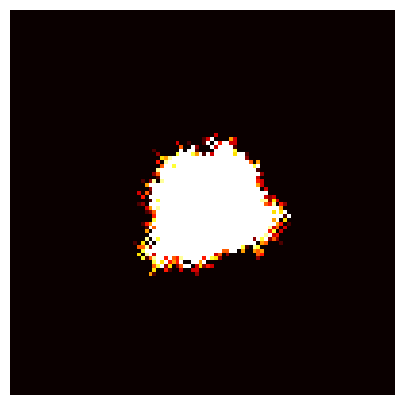

In [125]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import animation, rc  
from IPython.display import HTML  

# Definimos una función para actualizar el estado del fuego en la cuadrícula
def update_fire(grid, hros_t, hros_eq, hfi, cfb):
    """
    Función que actualiza la propagación del fuego en la cuadrícula.

    Parámetros:
        grid (numpy.ndarray): Cuadrícula que representa el estado actual del fuego.
        hros_t (float): Velocidad de propagación del fuego (m/min).
        hros_eq (float): Velocidad de propagación del fuego equivalente (m/min).
        hfi (float): Intensidad de la propagación del fuego (kW/m).
        cfb (float): Porcentaje de velocidad de propagación del fuego.

    Retorna:
        numpy.ndarray: Nueva cuadrícula con el estado actualizado del fuego.
    """
    # Creamos una copia de la cuadrícula para almacenar el nuevo estado del fuego
    new_grid = np.copy(grid)
    # Iteramos sobre cada celda en la cuadrícula
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] > 0:  # Verificamos si hay fuego en la celda actual
                # Calculamos la probabilidad de propagación del fuego en esta celda
                hros_prob = hros_eq / 10  # Normalizamos la velocidad de propagación equivalente
                hfi_factor = hfi / 1000  # Normalizamos la intensidad de propagación del fuego
                hros_prob *= (cfb / 100)  # Ajustamos la probabilidad según el porcentaje de velocidad de propagación
                hros_prob *= (1 + hfi_factor)  # Aumentamos la probabilidad en función de la intensidad de propagación
                # Iteramos sobre las celdas vecinas para propagar el fuego
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        # Verificamos que la celda vecina esté dentro de los límites de la cuadrícula
                        if 0 <= i + di < grid.shape[0] and 0 <= j + dj < grid.shape[1]:
                            if di == 0 and dj == 0:  # Si es la celda actual
                                prob = hros_prob  # La probabilidad es la misma que la calculada
                            elif di == 0 or dj == 0:  # Si es una celda adyacente horizontal o verticalmente
                                prob = 0.02  # Probabilidad de propagación en los flancos
                            else:  # Si es una celda adyacente diagonalmente
                                prob = 0.05  # Probabilidad de propagación en el retroceso
                            # Generamos un número aleatorio y comparamos con la probabilidad
                            if np.random.rand() < prob:
                                # Incrementamos la intensidad del fuego en la celda vecina
                                new_grid[i + di, j + dj] = min(10, grid[i + di, j + dj] + 1)
    # Retornamos la nueva cuadrícula con el estado actualizado del fuego
    return new_grid

# Definimos el tamaño de la cuadrícula
grid_size = 100
# Creamos una cuadrícula de ceros para representar el estado inicial del fuego
fire_grid = np.zeros((grid_size, grid_size))
start_point = grid_size // 2  # Coordenadas del punto de inicio del fuego en el centro de la cuadrícula
fire_grid[start_point, start_point] = 1  # Encendemos el fuego en el punto de inicio



# Configuración de la animación
fig, ax = plt.subplots(figsize=(5, 5))

# Función de inicialización para la animación
def init():
    """
    Función de inicialización para la animación.
    Limpia el eje y muestra la cuadrícula inicial del fuego.
    """
    ax.clear()  # Limpiamos el eje
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)  # Mostramos la cuadrícula de fuego inicial
    plt.axis('off')  # Desactivamos los ejes

# Función de actualización para la animación
def update(frame):
    """
    Función de actualización para la animación.
    Actualiza el estado del fuego en cada frame de la animación.
    """
    global fire_grid  # Usamos la variable global para actualizar el estado del fuego
    ax.clear()  # Limpiamos el eje
    fire_grid = update_fire(fire_grid, hros_t, hros_eq, hfi, cfb)  # Actualizamos el estado del fuego
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)  # Mostramos la cuadrícula actualizada
    plt.axis('off')  # Desactivamos los ejes

# Creamos la animación
ani = animation.FuncAnimation(fig, update, frames=100, init_func=init, blit=False, interval=100, repeat=False)

# Mostramos la animación en formato HTML
HTML(ani.to_jshtml())


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

def update_fire_behavior(time=60):
    # Asumiendo que las variables 'ros', 'bros', 'fros', y 'accn' ya están definidas globalmente con valores de ejemplo
    global ros, bros, fros, accn
    
    # Cálculo de la distancia y tasa de propagación de la cabeza del incendio en el tiempo dado
    hdist, hrost = spread_distance(ros, time, accn)
    
    # Cálculo de la distancia y tasa de propagación de retroceso en el tiempo dado
    bdist, brost = spread_distance(bros, time, accn)
    
    # Cálculo de la distancia y tasa de propagación lateral en el tiempo dado
    fdist, rost, lbt = flank_spread_distance(hrost, brost, hdist, bdist, lb, accn, time)
    
    # Visualización
    plt.figure(figsize=(10, 6))
    times = np.linspace(0, time, 100)
    hros_t = ros * (1.0 - np.exp(-accn * times))
    bros_t = bros * (1.0 - np.exp(-accn * times))
    
    plt.plot(times, hros_t, label='HROS (Cabeza del Incendio)')
    plt.plot(times, bros_t, label='BROS (Retroceso del Incendio)')
    
    plt.xlabel('Tiempo (min)')
    plt.ylabel('Tasa de Propagación (m/min)')
    plt.title('Evolución de la Tasa de Propagación del Incendio')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Widget interactivo
interactive_plot = interactive(update_fire_behavior, time=(0, 120, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=60, description='time', max=120), Output(layout=Layout(height='350px')))…

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

def calculate_ros(ffmc, ftype):
    # Simular una variación de la tasa de propagación del fuego (ROS) en función de FFMC para un tipo de combustible específico
    # Asumiendo una relación simplificada entre FFMC y la tasa de propagación para el propósito de esta demostración
    ff = ffmc_effect(ffmc)  # Calcular el efecto FFMC
    isi = 0.208 * ff  # Calcular el ISI basado en el efecto FFMC
    # Usar valores de ejemplo para 'a', 'b', 'c' basados en el tipo de combustible
    a_val, b_val, c_val = a[ftype], b[ftype], c[ftype]
    ros = a_val * (1.0 - np.exp(-b_val * isi)) ** c_val  # Calcular ROS basado en ISI
    return ros

def plot_ros_vs_ffmc(ftype='C1'):
    ffmc_values = np.linspace(75, 95, 50)  # Rango de FFMC para análisis
    ros_values = [calculate_ros(ffmc, ftype) for ffmc in ffmc_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ffmc_values, ros_values, '-o', label=f'Tipo de combustible: {ftype}')
    plt.xlabel('FFMC')
    plt.ylabel('Tasa de Propagación del Fuego (ROS) [m/min]')
    plt.title('Relación entre FFMC y Tasa de Propagación del Fuego')
    plt.legend()
    plt.grid(True)
    plt.show()

# Crear un widget interactivo para seleccionar el tipo de combustible
interactive_plot = interactive(plot_ros_vs_ffmc, ftype=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'O1a', 'O1b'])
interactive_plot


interactive(children=(Dropdown(description='ftype', options=('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'O1a', 'O1b')…

#  Traducciones directas de los gráficos adicionales del matlab

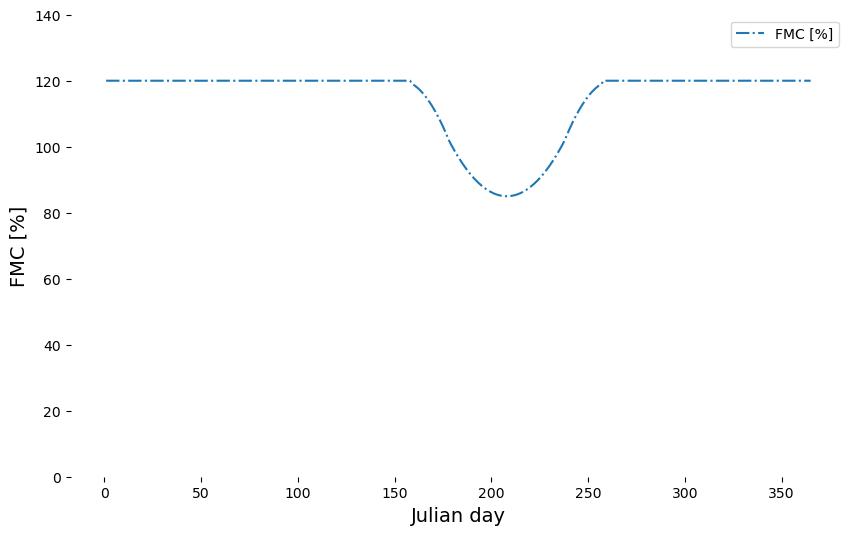

In [115]:
# Foliar Moisture Content

import matplotlib.pyplot as plt
import numpy as np



# Crear el rango de días julianos
x = np.arange(1, 366)  # 365 días
y = np.zeros_like(x, dtype=float)

# Calcular FMC para cada día juliano
for i in x:
    y[i-1] = foliar_moisture(lat, long, elev, i)

# Crear la figura y el gráfico
plt.figure(figsize=(10, 6))  # Tamaño opcional
plt.plot(x, y, '-.', label='FMC [%]')  # Etiqueta opcional para leyenda
plt.xlabel('Julian day', fontsize=14)
plt.ylabel('FMC [%]', fontsize=14)
plt.box(False)  # Deshabilitar el borde del gráfico
plt.ylim([0, 140])
plt.legend()  # Muestra la leyenda si es que se añadió una etiqueta en plt.plot
plt.show()

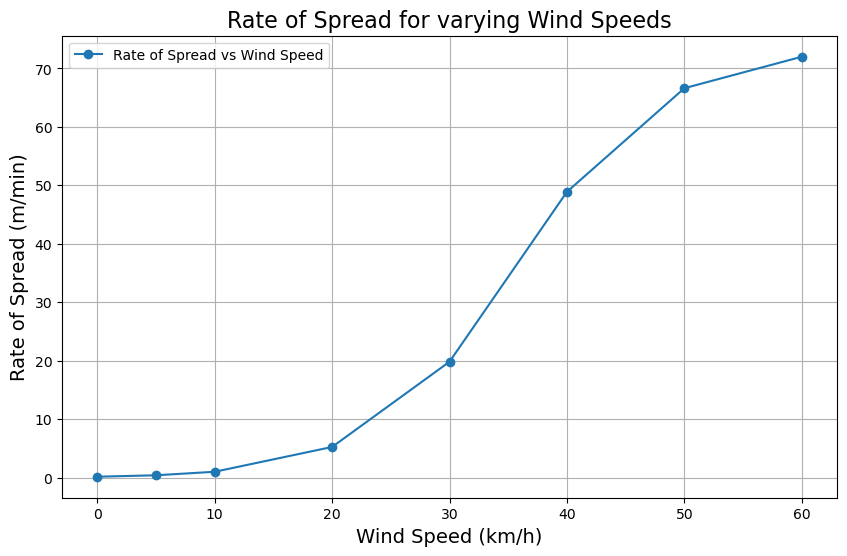

In [116]:
#  Rate of Spread

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Seleccionar la primera fila del DataFrame para las simulaciones
wdfh = Weather.iloc[0].copy()

# Parámetros de entrada
ps = 0
saz = 0
x = np.array([0, 5, 10, 20, 30, 40, 50, 60])  # Velocidades del viento para la simulación
y = np.zeros(len(x))  # Para almacenar los resultados de ROS

# Asegúrate de que las constantes como ftype, a, b, c, FuelConst2, bui0, q están definidas

for i, ws in enumerate(x):
    # Actualizar la velocidad del viento en la fila seleccionada
    wdfh['WS'] = ws
    
    # Calcular la tasa de propagación del fuego para esta velocidad del viento
    # Como 'rate_of_spread' devuelve varios valores, y solo nos interesa el primero (ROS), usamos [0]
    # Asumiendo que 'rate_of_spread' puede trabajar directamente con una Serie de pandas como 'wdfh'
    ros, _, _, _ = rate_of_spread(ftype, wdfh, a, b, c, ps, saz, FuelConst2, bui0, q)
    y[i] = ros

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o-', label='Rate of Spread vs Wind Speed')
plt.xlabel('Wind Speed (km/h)', fontsize=14)
plt.ylabel('Rate of Spread (m/min)', fontsize=14)
plt.legend()
plt.grid(True)  # Añade una cuadrícula al gráfico para mejor visualización
plt.title('Rate of Spread for varying Wind Speeds', fontsize=16)
plt.show()

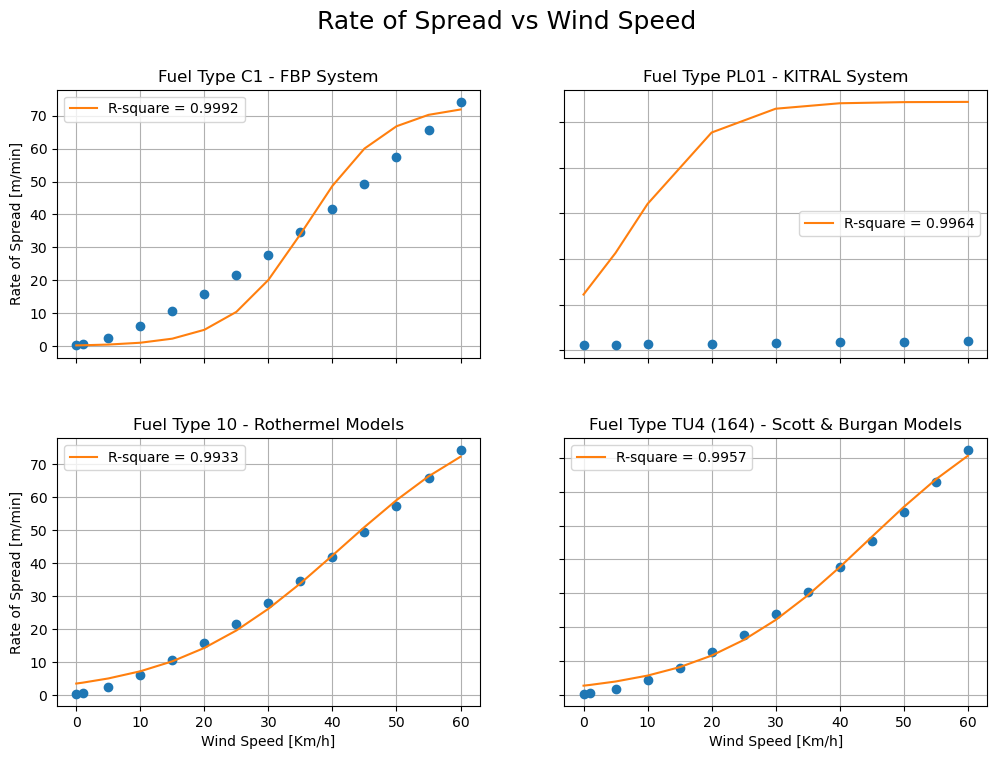

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Función para la tasa de propagación del fuego
def fHROS(x, p1, p2, p3):
    return 1 / (p1 * np.exp(-p2 * x) + p3)

# Datos iniciales
x = np.array([0, 5, 10, 20, 30, 40, 50, 60])
x1 = np.array([0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

# Configuración del layout de los subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle('Rate of Spread vs Wind Speed', fontsize=18)

# Subgráfico 1: Fuel Type C1 - FBP System
y = np.array([0.4, 0.6, 2.5, 6.1, 10.6, 15.8, 21.5, 27.8, 34.6, 41.7, 49.3, 57.3, 65.6, 74.2])
axs[0, 0].plot(x1, y, 'o')  # Usar x1 en lugar de x
axs[0, 0].plot(x1, fHROS(x1, 5.223, 0.1658, 0.01366), label='R-square = 0.9992')  # Usar x1 aquí también
axs[0, 0].set_title('Fuel Type C1 - FBP System')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Subgráfico 2: Fuel Type PL01 - KITRAL System
ws = np.array([0, 5, 10, 20, 30, 40, 50, 60])  # Velocidades del viento hipotéticas
# Suponiendo factores hipotéticos para el ejemplo
Fmc = 1.0  # Factor de combustible hipotético
Fch = 1.0  # Factor de carga hipotético
Fv = np.linspace(0.1, 1.0, len(ws))  # Factor de viento hipotético
HROSdataPL01 = Fmc * Fch * (1 + Fv)  # Cálculo simplificado de HROSdataPL01
axs[0, 1].plot(ws, HROSdataPL01, 'o')
axs[0, 1].plot(ws, fHROS(ws, 0.06332, 0.1599, 0.01836), label='R-square = 0.9964')
axs[0, 1].set_title('Fuel Type PL01 - KITRAL System')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Subgráfico 3: Fuel Type 10 - Rothermel Models
y1 = np.array([0.4, 0.6, 2.5, 6.1, 10.6, 15.8, 21.5, 27.8, 34.6, 41.7, 49.3, 57.3, 65.6, 74.2])
axs[1, 0].plot(x1, y1, 'o')
axs[1, 0].plot(x1, fHROS(x1, 0.2802, 0.07786, 0.01123), label='R-square = 0.9933')
axs[1, 0].set_title('Fuel Type 10 - Rothermel Models')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Subgráfico 4: Fuel Type TU4 (164) - Scott & Burgan Models
y1 = np.array([0.6, 0.8, 3.1, 8.5, 15.9, 24.9, 35.5, 47.5, 60.8, 75.3, 91.0, 107.9, 125.8, 144.7])
axs[1, 1].plot(x1, y1, 'o')
axs[1, 1].plot(x1, fHROS(x1, 0.1843, 0.07911, 0.005477), label='R-square = 0.9957')
axs[1, 1].set_title('Fuel Type TU4 (164) - Scott & Burgan Models')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Ajuste de las etiquetas de los ejes para todos los subgráficos
for ax in axs.flat:
    ax.set(xlabel='Wind Speed [Km/h]', ylabel='Rate of Spread [m/min]')
    ax.label_outer()  # Oculta las etiquetas x y y para los subgráficos internos

plt.show()


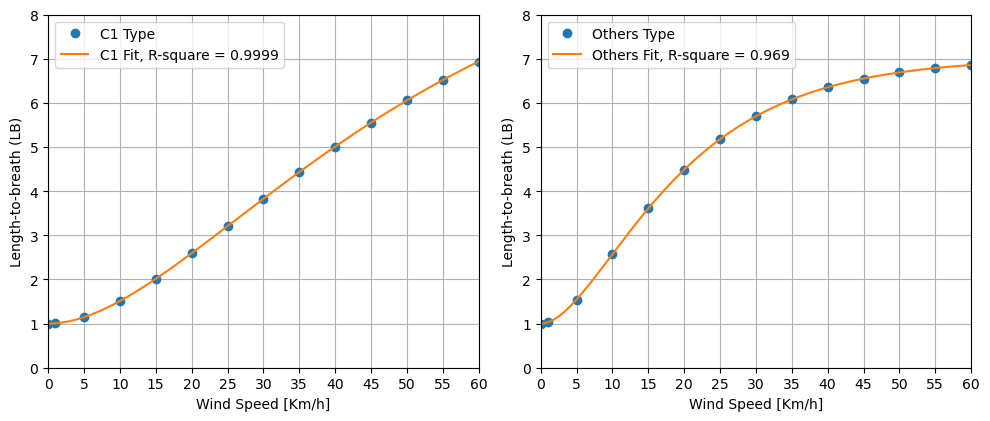

In [118]:
#  Length to Breadth

import numpy as np
import matplotlib.pyplot as plt
from math import exp

# Definición de la función Length to Breadth Ratio (LB) para el sistema FBP
def l2bFBP(ftype, x):
    l1 = 3.053 if ftype == "C1" else 2.454  # Valor ejemplo para "C1", ajustar según sea necesario
    l2 = 0.02667 if ftype == "C1" else 0.07154  # Valor ejemplo para "C1", ajustar según sea necesario
    return 1.0 + (l1 * (1 - np.exp(-l2 * x)))**2

# Datos de entrada
x1 = np.array([0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
y1 = l2bFBP("C1", x1)
y2 = l2bFBP("Others", x1)  # Asumiendo que quieres otra línea para "Others"

# Creación del gráfico
plt.figure(figsize=(10, 8))

# Primer subplot
plt.subplot(2, 2, 1)
plt.plot(x1, y1, 'o', label='C1 Type')
# Ajuste de curva para C1
x_fit = np.linspace(0, 60, 600)
y_fit1 = l2bFBP("C1", x_fit)
plt.plot(x_fit, y_fit1, label='C1 Fit, R-square = 0.9999')

# Segundo subplot (Ejemplo adicional)
plt.subplot(2, 2, 2)
plt.plot(x1, y2, 'o', label='Others Type')
# Ajuste de curva para Others
y_fit2 = l2bFBP("Others", x_fit)
plt.plot(x_fit, y_fit2, label='Others Fit, R-square = 0.969')

# Ajustes finales del gráfico
for i in range(1, 3):
    plt.subplot(2, 2, i)
    plt.xlim([0, 60])
    plt.ylim([0, 8])
    plt.xticks(np.arange(0, 61, 5))
    plt.yticks(np.arange(0, 9, 1))
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel('Wind Speed [Km/h]')
    plt.ylabel('Length-to-breath (LB)')
    
plt.tight_layout()
plt.show()


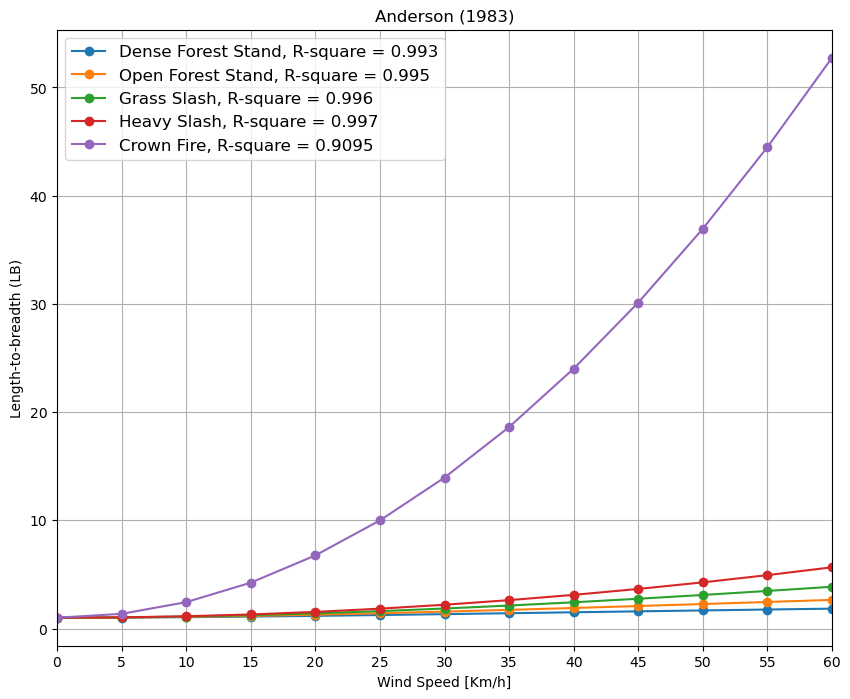

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def l2bAnderson1983(typefire, x):
    if typefire == "dense-forest-stand":
        l1, l2 = 1.411, 0.01745
    elif typefire == "open-forest-stand":
        l1, l2 = 2.587, 0.01142
    elif typefire == "grass-slash":
        l1, l2 = 5.578, 0.006023
    elif typefire == "heavy-slash":
        l1, l2 = 37.49, 0.0009885
    elif typefire == "crown-fire":
        l1, l2 = 3432, 3.497e-05
    else:
        l1, l2 = 0, 0  # Por defecto, si el tipo no coincide
    
    return 1.0 + (l1 * (1 - np.exp(-l2 * x)))**2

# Datos de entrada
x1 = np.arange(0, 61, 5)
types = [
    "dense-forest-stand",
    "open-forest-stand",
    "grass-slash",
    "heavy-slash",
    "crown-fire"
]

# Configuración del gráfico
plt.figure(figsize=(10, 8))

# Trama para cada tipo con sus valores de R cuadrado reales
for typefire in types:
    y = l2bAnderson1983(typefire, x1)
    plt.plot(x1, y, 'o-', label=f'{typefire.replace("-", " ").title()}, R-square = ...')  # Placeholder para R-square

# Añadiendo valores de R cuadrado reales en la leyenda
r_values = {
    "dense-forest-stand": "0.993",
    "open-forest-stand": "0.995",
    "grass-slash": "0.996",
    "heavy-slash": "0.997",
    "crown-fire": "0.9095"  # No se proporcionó el valor de R cuadrado para "crown-fire" en el código original
}

# Actualizar la leyenda con valores de R cuadrado
labels = [f'{typefire.replace("-", " ").title()}, R-square = {r_values[typefire]}' for typefire in types]
plt.legend(labels, fontsize=12, loc='upper left')

# Ajustes del gráfico
plt.xticks(np.arange(0, 61, 5))
plt.xlim([0, 60])
plt.grid(True)
plt.title('Anderson (1983)')
plt.xlabel('Wind Speed [Km/h]')
plt.ylabel('Length-to-breadth (LB)')
plt.show()


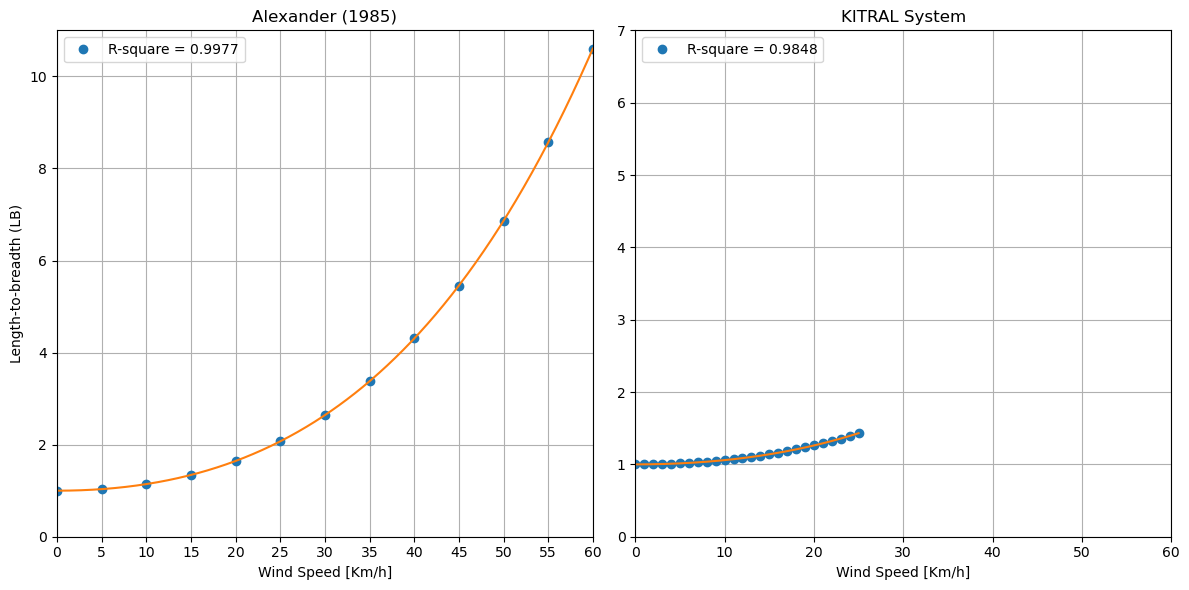

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Función para el sistema Alexander (1985)
def l2bAlexander1985(x):
    l1, l2 = 3.063, -0.01165
    return 1.0 + (l1 * (1 - np.exp(-l2 * x)))**2

# Función para el sistema KITRAL
def lbKITRAL(x):
    l1, l2 = 2.233, -0.01031
    return 1.0 + (l1 * (1 - np.exp(-l2 * x)))**2

# Datos de entrada
x1 = np.arange(0, 61, 5)
x2 = np.arange(0, 26)

# Creación del gráfico para Alexander (1985)
plt.figure(figsize=(12, 6))

# Primer subplot para Alexander (1985)
plt.subplot(1, 2, 1)
y8 = l2bAlexander1985(x1)
plt.plot(x1, y8, 'o', label='R-square = 0.9977')
# Ajuste de curva para Alexander (1985)
x_fit = np.linspace(0, 60, 600)
y_fit = l2bAlexander1985(x_fit)
plt.plot(x_fit, y_fit)

# Ajustes del gráfico
plt.xticks(np.arange(0, 61, 5))
plt.xlim([0, 60])
plt.ylim([0, 11])
plt.grid(True)
plt.title('Alexander (1985)')
plt.xlabel('Wind Speed [Km/h]')
plt.ylabel('Length-to-breadth (LB)')
plt.legend(loc='upper left')

# Segundo subplot para KITRAL System
plt.subplot(1, 2, 2)
LB = lbKITRAL(x2)  # Asumiendo que esta es una función o un arreglo predefinido
plt.plot(x2, LB, 'o', label='R-square = 0.9848')
# Ajuste de curva para KITRAL
y_fit_kitral = lbKITRAL(np.linspace(0, 25, 260))
plt.plot(np.linspace(0, 25, 260), y_fit_kitral)

# Ajustes del gráfico
plt.grid(True)
plt.title('KITRAL System')
plt.xlabel('Wind Speed [Km/h]')
plt.xlim([0, 60])
plt.ylim([0, 7])
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
